# Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

# Load Data

In [3]:
from helper_functions import subject_df

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/helper_functions.py:23: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../02_analysis/df_good.csv')


In [4]:
import warnings

warnings.filterwarnings('ignore')

# Function to load all participants
df_good = pd.read_csv('../02_analysis/df_good.csv')

## Feature Selection

Take the features that were significant ($\text{z-score} >= 2$) based on the dimension reduction MLM run in notebook `05_model_comp_categorical.ipynb`

In [28]:
mlm_features = pd.read_csv('mlm_results.csv')

mlm_features.shape

(4061, 8)

In [29]:
mlm_features.head()

,feature,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],Converged
0,affect_neg_angry,1.235627,0.675440,1.829365,0.067345,-0.088212,2.559466,True
1,affect_neg_ashamed,2.291697,0.730526,3.137050,0.001707,0.859892,3.723501,True
2,affect_neg_bored,2.658913,0.735074,3.617207,0.000298,1.218195,4.099631,True
3,affect_neg_depressed,2.185955,0.610614,3.579928,0.000344,0.989173,3.382737,True
4,affect_neg_embarrassed,1.603450,0.701724,2.285016,0.022312,0.228097,2.978803,True


In [25]:
feature_filter_all = list(mlm_features.loc[np.abs(mlm_features.z)>=2].feature)

print(f'Total number of features with z-score greater than 2: {len(feature_filter_all)}')

Total number of features with z-score greater than 2: 588


In [26]:
feature_filter_passive = mlm_features.loc[(mlm_features.feature.str.startswith('passive')) & (np.abs(mlm_features.z)>=2)]

print(f'Total number of passive features with z-score greater than 2: {len(feature_filter_passive)}')

Total number of passive features with z-score greater than 2: 79


In [27]:
feature_filter_passive_task = mlm_features.loc[(mlm_features.feature.str.startswith('passive') | mlm_features.feature.str.startswith('task')) & (np.abs(mlm_features.z)>=2)]

print(f'Total number of passive and task features with z-score greater than 2: {len(feature_filter_passive_task)}')

Total number of passive and task features with z-score greater than 2: 217


## Target column

In [15]:
# Define a function to calculate the 3-day moving average with forward-looking window
def forward_moving_average(series, window=3):
    return series.rolling(window=window, min_periods=1).mean().shift(-window)

# Apply the moving average calculation for each PID
df_good['target'] = df_good.groupby('PID')['sr_gap_heuristic'].transform(lambda x: forward_moving_average(x, window=3))

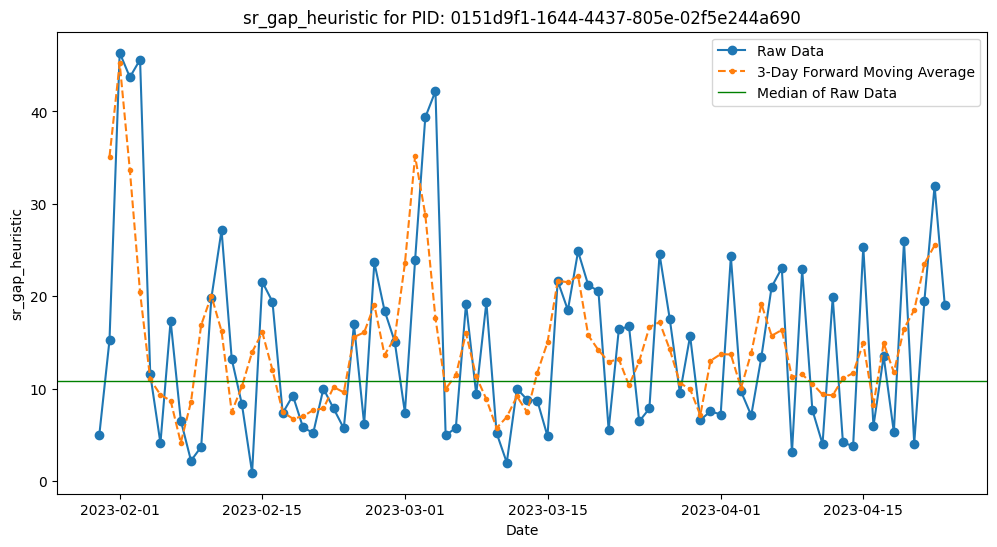

In [39]:
# Visualize a couple subjects with both original and three day smoothed gap

# Moving the target column forward 1 day as it is the mean of (current day + 1, cd + 2, cd + 3)
# so target for day 7, really represents the rolling average  of days 8, 9 and 10, so by moving
# it forward a day it is associated with day 8 instead of day 7

# Selecting two PIDs
pids = df_good['PID'].unique()[:1]

# Filter the dataframe for the PIDs
df_filtered = df_good[df_good['PID'].isin(pids)][['PID', 'trial_date', 'sr_gap_heuristic', 'target']]

# Plot the data for each PID
for pid in pids:
    df_pid = df_filtered[df_filtered['PID'] == pid]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_pid['trial_date'], df_pid['sr_gap_heuristic'], label='Raw Data', marker='o')
    plt.plot(df_pid['trial_date'], df_pid['target'].shift(1), label='3-Day Forward Moving Average', linestyle='--', marker='.')
    
    # Add a horizontal line at the median of the raw data
    median_value = df_pid['sr_gap_heuristic'].median()
    plt.axhline(median_value, color='green', linestyle='-', linewidth=1, label='Median of Raw Data')
    
    plt.title(f'sr_gap_heuristic for PID: {pid}')
    plt.xlabel('Date')
    plt.ylabel('sr_gap_heuristic')
    plt.legend()
    plt.show()

# Fit Model

In [54]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['subject', 'data_version', 'split_day', 'linear_reg', 'random_forest', 'xgboost', 'ensemble', 'ffill',
                                   'predictions_lr', 'predictions_rf', 'predictions_xgb', 'predictions_e'])

# How many features to use
num_features = 12

# Loop through subjects
for i in range(len(np.unique(df_good.PID))):
    print("Subject", i)
    
    try:
        # Feature engineering for subject
        df_split = subject_df(df_good, sub_num=i)
        
        # Separate features and target variable
        X = df_split.drop(columns=['target'])
        y = df_split['target']
        
        # Loop through data versions (3)
        for dataVersion in range(3):
            print("Data Version:", dataVersion)
            
            # Filter based on predictive features from MLM for given data version
            if dataVersion == 0:
                # Filter columns_to_keep to include only those that exist in the DataFrame
                filtered_cols = [col for col in feature_filter_all if col in X.columns]
                
            elif dataVersion == 1:
                # Filter columns_to_keep to include only those that exist in the DataFrame
                filtered_cols = [col for col in feature_filter_passive_task if col in X.columns]
                
            elif dataVersion == 2:
                # Filter columns_to_keep to include only those that exist in the DataFrame
                filtered_cols = [col for col in feature_filter_passive if col in X.columns]
            
            # Filter features
            X = X[filtered_cols]

            # Remove initial rows with NaN values for target
            while y.isnull().iloc[0]:
                X = X.iloc[1:].reset_index(drop=True)
                y = y.iloc[1:].reset_index(drop=True)
            
            # Count missing values before imputation
            missing_values_before = y.isnull().sum()

            # Impute missing values in the target variable using forward fill
            y = y.fillna(method='ffill')

            # Count missing values after imputation
            missing_values_after = y.isnull().sum()

            # Calculate the number of imputed values
            imputed_value_count = missing_values_before - missing_values_after

            # Iterate through split points
            for splitDay in range(20, len(X)-3):
                print("Split Day:", splitDay)

                # Ensure there are no more NaN values in y
                if y.isnull().sum() == 0:
                    # Create train and test sets where we predict the next 3 days only
                    X_train, X_test = X[:splitDay], X[splitDay:splitDay+3]
                    y_train, y_test = y[:splitDay], y[splitDay:splitDay+3]
                    
                    # Handle missing values and standardize features
                    imputer = SimpleImputer(strategy='mean')
                    scaler = StandardScaler()

                    # Feature selection
                    k_best = SelectKBest(score_func=f_regression, k=num_features)

                    # Models
                    lin_reg = LinearRegression()
                    rf = RandomForestRegressor(n_estimators=100)
                    xgb_reg = xgb.XGBRegressor(n_estimators=100)

                    # TimeSeriesSplit
                    tscv = TimeSeriesSplit(n_splits=5)

                    # Pipelines
                    lin_reg_pipeline = Pipeline([
                        ('imputer', imputer),
                        ('scaler', scaler),
                        ('k_best', k_best),
                        ('regressor', lin_reg)
                    ])

                    rf_pipeline = Pipeline([
                        ('imputer', imputer),
                        ('scaler', scaler),
                        ('k_best', k_best),
                        ('regressor', rf)
                    ])

                    xgb_pipeline = Pipeline([
                        ('imputer', imputer),
                        ('scaler', scaler),
                        ('k_best', k_best),
                        ('regressor', xgb_reg)
                    ])

                    # Define the parameter grids for each model
                    param_grid_lin_reg = {
                        'regressor__fit_intercept': [True, False]
                    }

                    param_grid_rf = {
                        #'regressor__n_estimators': [50, 100, 200],
                        'regressor__n_estimators': [50, 100],
                        #'regressor__max_depth': [None, 10, 20, 30]
                        'regressor__max_depth': [None, 20]
                    }

                    param_grid_xgb = {
                        # 'regressor__n_estimators': [50, 100, 200],
                        # 'regressor__learning_rate': [0.01, 0.1, 0.3],
                        # 'regressor__max_depth': [3, 6, 9],
                        # 'regressor__reg_alpha': [0, 0.1, 0.5],
                        # 'regressor__reg_lambda': [0, 0.5, 1]
                        'regressor__n_estimators': [100],
                        'regressor__learning_rate': [0.05, 0.3],
                        'regressor__max_depth': [6],
                        'regressor__reg_alpha': [0],
                        'regressor__reg_lambda': [1]
                    }

                    # Setup GridSearchCV for each model
                    grid_lin_reg = GridSearchCV(lin_reg_pipeline, param_grid_lin_reg, cv=tscv, scoring='neg_mean_squared_error')
                    grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=tscv, scoring='neg_mean_squared_error')
                    grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=tscv, scoring='neg_mean_squared_error')

                    # Fit the models
                    grid_lin_reg.fit(X_train, y_train)
                    grid_rf.fit(X_train, y_train)
                    grid_xgb.fit(X_train, y_train)

                    # Print best parameters for the XGBoost model
                    print("Best parameters for XGBoost:", grid_xgb.best_params_)

                    # Best estimators
                    best_lin_reg = grid_lin_reg.best_estimator_
                    best_rf = grid_rf.best_estimator_
                    best_xgb = grid_xgb.best_estimator_

                    # Ensemble with VotingRegressor
                    voting_reg = VotingRegressor(estimators=[
                        ('lin_reg', best_lin_reg),
                        ('rf', best_rf),
                        ('xgb', best_xgb)
                    ])
                    
                    # Cross-validation for ensemble model
                    ensemble_scores = cross_val_score(voting_reg, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
                    ensemble_rmse = np.sqrt(-ensemble_scores.mean())

                    # The average performance of the best models across the cross-validation folds
                    results = {
                        'Linear Regression': np.sqrt(-grid_lin_reg.best_score_),
                        'Random Forest': np.sqrt(-grid_rf.best_score_),
                        'XGBoost': np.sqrt(-grid_xgb.best_score_),
                        'Ensemble': ensemble_rmse
                    }
                    
                    # Feature importance list
                    selector = best_xgb.named_steps['k_best']
                    xgb_model = best_xgb.named_steps['regressor']

                    mask = selector.get_support()  # Boolean mask
                    selected_indices = selector.get_support(indices=True)  # Indices of selected features
                    selected_feature_names = X.columns[selected_indices]

                    importances = xgb_model.feature_importances_

                    feature_importances = sorted(zip(selected_feature_names, importances), key=lambda x: x[1], reverse=True)
                    feature_dict = {feature: importance for feature, importance in feature_importances}

                    # Predict on held out data (3 days)
                    # Make predictions using the best Linear Regression Model
                    best_lin_reg.fit(X_train, y_train)
                    y_pred = best_lin_reg.predict(X_test)
                    prediction_dict_lr = [{'predicted_lr_value': pred, 'actual_value': actual} for pred, actual in zip(y_pred, y_test)]
                    
                    # Make predictions using the best RF model
                    best_rf.fit(X_train, y_train)
                    y_pred = best_rf.predict(X_test)
                    prediction_dict_rf = [{'predicted_rf_value': pred, 'actual_value': actual} for pred, actual in zip(y_pred, y_test)]
                    
                    # Make predictions using the best XGBoost model
                    best_xgb.fit(X_train, y_train)
                    y_pred_ensemble = best_xgb.predict(X_test)
                    prediction_dict_xgb = [{'predicted_xgb_value': pred, 'actual_value': actual} for pred, actual in zip(y_pred, y_test)]
                    
                    # Make predictions using the best Ensemble model
                    voting_reg.fit(X_train, y_train)
                    y_pred = voting_reg.predict(X_test)
                    prediction_dict_e = [{'predicted_e_value': pred, 'actual_value': actual} for pred, actual in zip(y_pred, y_test)]

                    # Save results to the DataFrame using pd.concat
                    new_row = pd.DataFrame({
                        'subject': [i],
                        'data_version': dataVersion,
                        'split_day': splitDay,
                        'linear_reg': [np.sqrt(-grid_lin_reg.best_score_)],
                        'random_forest': [np.sqrt(-grid_rf.best_score_)],
                        'xgboost': [np.sqrt(-grid_xgb.best_score_)],
                        'ensemble': [ensemble_rmse],
                        'ffill': [imputed_value_count],
                        'feature_import_xgb': [feature_dict],
                        'predictions_lr': [prediction_dict_lr],
                        'predictions_rf': [prediction_dict_rf],
                        'predictions_xgb': [prediction_dict_xgb],
                        'predictions_e': [prediction_dict_e]
                    })
                    results_df = pd.concat([results_df, new_row], ignore_index=True)
                    
                else:
                    print(f"Skipping subject {i} because the target variable y still contains NaN values after imputation.")
                    continue
    except KeyError as err:
        print(f'Error with subject {i} in subject_df() function: {err}')


Subject 0
Data Version: 0
Split Day: 20
Best parameters for XGBoost: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__reg_alpha': 0.1, 'regressor__reg_lambda': 1}
Split Day: 21
Best parameters for XGBoost: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 50, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 0}
Split Day: 22
Best parameters for XGBoost: {'regressor__learning_rate': 0.3, 'regressor__max_depth': 3, 'regressor__n_estimators': 50, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 1}
Split Day: 23
Best parameters for XGBoost: {'regressor__learning_rate': 0.3, 'regressor__max_depth': 3, 'regressor__n_estimators': 50, 'regressor__reg_alpha': 0.5, 'regressor__reg_lambda': 0}
Split Day: 24
Best parameters for XGBoost: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 6, 'regressor__n_estimators': 100, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 0}
Split Day: 25
Bes

KeyboardInterrupt: 

In [55]:
results_df

,subject,data_version,split_day,linear_reg,random_forest,xgboost,ensemble,ffill,predictions_lr,predictions_rf,predictions_xgb,predictions_e,feature_import_xgb
0,0,0,20,0.483106,0.181399,0.152743,0.220917,3,"[{'predicted_lr_value': 0.02722104827359903, '...","[{'predicted_rf_value': 0.14557629870129868, '...","[{'predicted_xgb_value': 0.14557629870129868, ...","[{'predicted_e_value': 0.11899237730562685, 'a...",{'task_hanoi_movesTime_model_predict': 0.50680...
1,0,0,21,0.560484,0.179364,0.144926,0.197134,3,"[{'predicted_lr_value': -0.1668015179888182, '...","[{'predicted_rf_value': 0.10923701298701294, '...","[{'predicted_xgb_value': 0.10923701298701294, ...","[{'predicted_e_value': 0.010671841380961439, '...",{'task_hanoi_movesTime_model_predict': 0.38467...
2,0,0,22,0.246302,0.127836,0.141738,0.117908,3,"[{'predicted_lr_value': -0.013139851796583835,...","[{'predicted_rf_value': 0.11684659090909083, '...","[{'predicted_xgb_value': 0.11684659090909083, ...","[{'predicted_e_value': 0.07088059628589219, 'a...",{'passive_sk_device_total_usage_health_and_fit...
3,0,0,23,0.486687,0.121263,0.117677,0.185274,3,"[{'predicted_lr_value': -0.12299898509316781, ...","[{'predicted_rf_value': 0.09709821428571425, '...","[{'predicted_xgb_value': 0.09709821428571425, ...","[{'predicted_e_value': 0.04047460122205426, 'a...",{'task_hanoi_movesTime_model_predict': 0.50037...
4,0,0,24,0.583403,0.261211,0.294501,0.287033,3,"[{'predicted_lr_value': -0.10534773731091293, ...","[{'predicted_rf_value': 0.10448051948051948, '...","[{'predicted_xgb_value': 0.10448051948051948, ...","[{'predicted_e_value': 0.04854138222706104, 'a...",{'task_trailmaking_alphaNumeric_time_rolling_m...
5,0,0,25,0.362738,0.177734,0.152082,0.199542,3,"[{'predicted_lr_value': 0.11709080406718508, '...","[{'predicted_rf_value': 0.13954545454545453, '...","[{'predicted_xgb_value': 0.13954545454545453, ...","[{'predicted_e_value': 0.13677411576926474, 'a...",{'task_trailmaking_alphaNumeric_time_rolling_m...
6,0,0,26,0.428081,0.148777,0.135879,0.208096,3,"[{'predicted_lr_value': 0.7773641631145995, 'a...","[{'predicted_rf_value': 0.2692268668831167, 'a...","[{'predicted_xgb_value': 0.2692268668831167, '...","[{'predicted_e_value': 0.42453233162121623, 'a...",{'task_hanoi_movesTime_model_predict': 0.46790...
7,0,0,27,0.590479,0.122167,0.114680,0.237711,3,"[{'predicted_lr_value': 0.21584229925049864, '...","[{'predicted_rf_value': 0.15550730519480513, '...","[{'predicted_xgb_value': 0.15550730519480513, ...","[{'predicted_e_value': 0.22102552992636856, 'a...",{'task_hanoi_movesTime_model_predict': 0.69040...
8,0,0,28,0.572714,0.145451,0.142323,0.193892,3,"[{'predicted_lr_value': 0.06000462074454821, '...","[{'predicted_rf_value': 0.2449797077922078, 'a...","[{'predicted_xgb_value': 0.2449797077922078, '...","[{'predicted_e_value': 0.18722315247664234, 'a...",{'task_hanoi_movesTime_model_predict': 0.51754...
9,0,0,29,0.365862,0.113686,0.117198,0.170762,3,"[{'predicted_lr_value': 0.1478672794473827, 'a...","[{'predicted_rf_value': 0.3190564123376619, 'a...","[{'predicted_xgb_value': 0.3190564123376619, '...","[{'predicted_e_value': 0.2612156224895412, 'ac...",{'affect_neg_lazy_exponential_rolling_mean_7':...


In [56]:
results_df.predictions_xgb[0]

[{'predicted_xgb_value': 0.14557629870129868,
  'actual_value': 0.08603896103896103},
 {'predicted_xgb_value': 0.10489448051948048,
  'actual_value': 0.09009740259740262},
 {'predicted_xgb_value': 0.13443181818181812,
  'actual_value': 0.14650974025974026}]

In [59]:
results_df.predictions_xgb[1]

[{'predicted_xgb_value': 0.10923701298701294,
  'actual_value': 0.09009740259740262},
 {'predicted_xgb_value': 0.1326136363636363,
  'actual_value': 0.14650974025974026},
 {'predicted_xgb_value': 0.09663149350649342,
  'actual_value': 0.13271103896103895}]

In [58]:
results_df.to_csv('results_df.csv', index=False)